# 缩放
图像缩放是预处理图像数据的一种聪明方法，理想情况下在去除噪声和背景之后进行。它允许将图像大小减小到仍然可以回答科学问题的程度，同时还能处理内存限制问题。例如，如果计算机报告内存不足错误，将图像缩小到较小的尺寸是继续项目的首选方法。此外，许多分割算法和定量测量方法都以像素/体素等距性为前提条件：体素在所有方向上必须具有相同的大小，否则此类算法的结果可能会产生误导或甚至是错误的。

In [1]:
import pyclesperanto_prototype as cle
import matplotlib.pyplot as plt
from skimage.io import imread

为了演示缩放，我们使用来自[Broad Bio Image Challenge](https://bbbc.broadinstitute.org/BBBC032)的裁剪和重采样图像数据：
Ljosa V, Sokolnicki KL, Carpenter AE (2012). Annotated high-throughput microscopy image sets for validation. Nature Methods 9(7):637 / doi. PMID: 22743765 PMCID: PMC3627348. 可在 http://dx.doi.org/10.1038/nmeth.2083 获取

In [2]:
input_image = imread("../../data/BMP4blastocystC3-cropped_resampled_8bit.tif")

# 体素大小在所有方向上并不相等； 
# 体素是各向异性的。
voxel_size_x = 0.202
voxel_size_y = 0.202
voxel_size_z = 1

当沿三个轴可视化该数据集的投影时，你会看到体素并不是各向同性的。

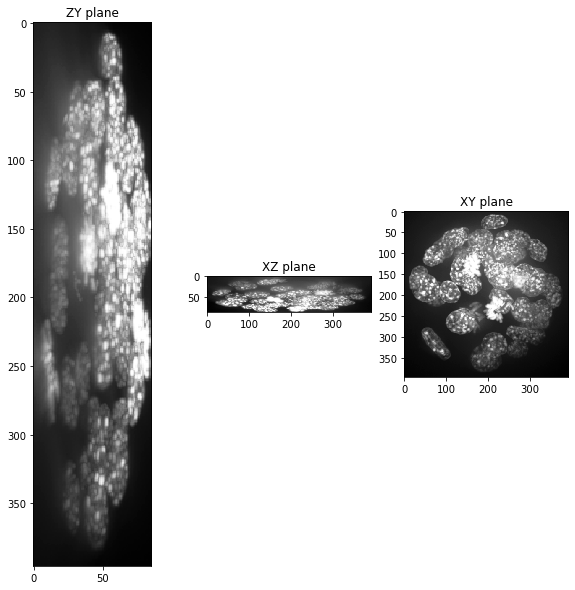

In [3]:
def show(image_to_show, labels=False):
    """
    此函数生成三个投影：X、Y和Z方向，并显示它们。
    """
    projection_x = cle.maximum_x_projection(image_to_show)
    projection_y = cle.maximum_y_projection(image_to_show)
    projection_z = cle.maximum_z_projection(image_to_show)

    fig, axs = plt.subplots(1, 3, figsize=(10, 10))
    cle.imshow(projection_x, plot=axs[0], labels=labels)
    cle.imshow(projection_y, plot=axs[1], labels=labels)
    cle.imshow(projection_z, plot=axs[2], labels=labels)
    axs[0].set_title("ZY平面")
    axs[1].set_title("XZ平面")
    axs[2].set_title("XY平面")
    plt.show()

show(input_image)

## 使用体素大小进行缩放
解决这个问题最简单的方法是用体素大小来缩放数据集。根据定义，这将产生一个体素在所有方向上都是各向同性的数据集，并且在所有方向上`voxel_size = 1`（在我们的例子中是微米）。

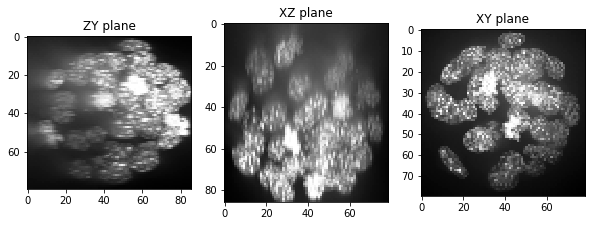

In [4]:
scale_factor_x = voxel_size_x
scale_factor_y = voxel_size_y
scale_factor_z = voxel_size_z

resampled = cle.scale(input_image, 
                      factor_x=scale_factor_x, 
                      factor_y=scale_factor_y, 
                      factor_z=scale_factor_z, 
                      linear_interpolation=True,
                      auto_size=True)

show(resampled)

重采样后的堆栈在X和Y方向上现在有更少的体素，这在准确分割对象时可能会成为问题。我们可以通过打印原始数据和重采样图像的形状来清楚地看到这一点。这是图像堆栈在深度-高度-宽度（Z-Y-X）方向上的大小。

In [5]:
input_image.shape

(86, 396, 393)

In [6]:
resampled.shape

(86, 80, 79)

一个潜在的解决方案是引入一个`zoom_factor`。它允许调整重采样图像的大小：

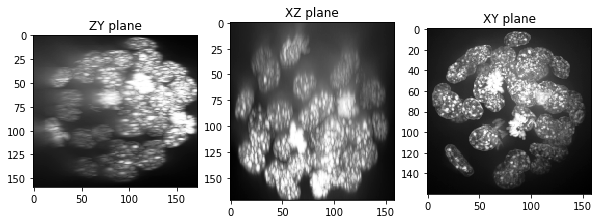

In [7]:
zoom_factor = 2

scale_factor_x = voxel_size_x * zoom_factor
scale_factor_y = voxel_size_y * zoom_factor
scale_factor_z = voxel_size_z * zoom_factor

resampled_zoomed = cle.scale(input_image, 
                      factor_x=scale_factor_x, 
                      factor_y=scale_factor_y, 
                      factor_z=scale_factor_z, 
                      linear_interpolation=True,
                      auto_size=True)

show(resampled_zoomed)

In [8]:
resampled_zoomed.shape

(172, 160, 159)

在缩放/放大3D图像时，请记住内存限制。你可以在以下视图的右侧框中读取图像的大小。像上面的例子那样将图像放大2倍，会使3D堆栈的图像大小增加8倍（2x2x2）。

cl.OCLArray([[[19.976562  , 20.        , 20.12207   , ..., 20.995056  ,
         19.996155  , 19.889374  ],
        [20.        , 19.14293   , 20.074219  , ..., 20.074219  ,
         20.151886  , 20.8125    ],
        [20.        , 19.884277  , 20.        , ..., 21.69043   ,
         20.731445  , 20.113281  ],
        ...,
        [ 8.        ,  8.9878235 , 10.104492  , ...,  6.1640625 ,
          7.        ,  5.8545227 ],
        [ 8.889374  ,  8.925781  ,  8.224121  , ...,  6.6996765 ,
          5.2587585 ,  5.        ],
        [ 8.021973  ,  8.879639  ,  8.0625    , ...,  6.        ,
          5.9375    ,  5.8867188 ]],

       [[18.99945   , 19.904083  , 19.        , ..., 19.976562  ,
         19.019592  , 19.        ],
        [20.        , 19.        , 20.        , ..., 19.464783  ,
         19.151886  , 19.934189  ],
        [19.        , 19.810059  , 19.765625  , ..., 20.81543   ,
         20.        , 19.113281  ],
        ...,
        [ 8.        ,  8.226105  ,  9.104492  , ...,  6.        ,
          5.3012085 ,  5.8867188 ],
        [ 8.        ,  8.991592  ,  8.        , ...,  6.        ,
          5.7598267 ,  5.0128326 ],
        [ 8.        ,  8.        ,  8.        , ...,  5.0493164 ,
          5.052246  ,  5.        ]],

       [[18.022888  , 19.904083  , 19.020508  , ..., 18.794006  ,
         19.        , 19.        ],
        [19.        , 19.925781  , 19.189941  , ..., 20.        ,
         19.151886  , 19.        ],
        [18.023438  , 19.009277  , 19.        , ..., 20.875     ,
         19.979492  , 19.        ],
        ...,
        [ 7.996155  ,  8.773895  ,  8.979492  , ...,  5.965393  ,
          5.862854  ,  5.        ],
        [ 8.        ,  8.886719  ,  8.        , ...,  6.        ,
          5.094696  ,  5.1004486 ],
        [ 8.        ,  8.        ,  7.9921875 , ...,  5.        ,
          5.8359375 ,  5.        ]],

       ...,

       [[ 1.        ,  1.0724792 ,  1.        , ...,  2.        ,
          2.8163452 ,  2.        ],
        [ 1.9765625 ,  1.9944916 ,  1.875     , ...,  2.195282  ,
          2.        ,  2.        ],
        [ 1.0205078 ,  1.8100586 ,  2.        , ...,  2.9013672 ,
          2.2480469 ,  2.224121  ],
        ...,
        [ 0.9804077 ,  2.        ,  1.        , ...,  2.965393  ,
          2.8359375 ,  2.        ],
        [ 0.13406372,  0.24490356,  1.        , ...,  2.1870422 ,
          2.1454773 ,  2.        ],
        [ 1.        ,  1.        ,  1.        , ...,  2.        ,
          1.2163086 ,  2.        ]],

       [[ 1.9536743 ,  1.0742188 ,  1.        , ...,  2.0049438 ,
          2.        ,  2.        ],
        [ 1.0724792 ,  1.        ,  1.        , ...,  2.        ,
          2.        ,  1.1790924 ],
        [ 1.1220703 ,  1.1157227 ,  1.875     , ...,  2.7890625 ,
          2.        ,  2.        ],
        ...,
        [ 1.        ,  1.0620422 ,  1.7314453 , ...,  2.965393  ,
          2.725708  ,  2.0185852 ],
        [ 1.        ,  1.        ,  1.875     , ...,  2.        ,
          2.0185852 ,  2.1004486 ],
        [ 0.97802734,  1.9375    ,  1.        , ...,  2.        ,
          2.        ,  1.9445801 ]],

       [[ 1.9536743 ,  1.        ,  1.0205078 , ...,  2.0049438 ,
          2.        ,  2.        ],
        [ 1.        ,  1.0055084 ,  1.0742188 , ...,  2.7304993 ,
          2.9379578 ,  1.9341888 ],
        [ 0.8779297 ,  1.        ,  1.890625  , ...,  2.9013672 ,
          2.        ,  2.875     ],
        ...,
        [ 1.        ,  1.151886  ,  1.0205078 , ...,  3.        ,
          2.862854  ,  2.0185852 ],
        [ 0.0234375 ,  0.93418884,  1.        , ...,  2.7890625 ,
          2.        ,  2.        ],
        [ 1.        ,  1.0578613 ,  1.        , ...,  2.7890625 ,
          2.        ,  2.        ]]], dtype=float32)
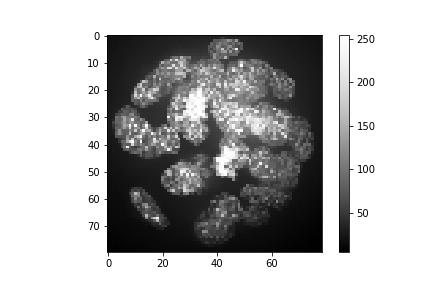
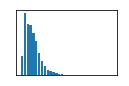

In [9]:
resampled

cl.OCLArray([[[14.25      , 14.25      , 14.826965  , ..., 14.25      ,
         14.736328  , 13.757721  ],
        [14.961914  , 14.25      , 15.        , ..., 14.841797  ,
         14.25      , 14.351715  ],
        [14.803711  , 14.65686   , 14.838867  , ..., 14.941406  ,
         14.583252  , 14.871094  ],
        ...,
        [ 6.359047  ,  6.        ,  6.1812744 , ...,  3.75      ,
          3.8426971 ,  4.4164124 ],
        [ 6.587448  ,  6.        ,  6.088623  , ...,  3.75      ,
          3.9683533 ,  4.2643433 ],
        [ 5.94096   ,  6.        ,  6.        , ...,  3.75      ,
          3.6037216 ,  4.1842804 ]],

       [[18.846611  , 19.        , 19.576965  , ..., 18.78125   ,
         19.398438  , 18.25772   ],
        [19.698112  , 19.155655  , 19.802734  , ..., 19.591797  ,
         18.76854   , 19.13562   ],
        [19.594727  , 19.40686   , 19.588867  , ..., 19.623047  ,
         19.444702  , 19.871094  ],
        ...,
        [ 8.31662   ,  8.        ,  8.153809  , ...,  5.        ,
          5.2548065 ,  5.6664124 ],
        [ 8.587448  ,  7.7929688 ,  8.088623  , ...,  5.005371  ,
          5.3526    ,  5.5143433 ],
        [ 7.8952103 ,  7.940666  ,  8.        , ...,  5.        ,
          4.9151764 ,  5.2895203 ]],

       [[18.539833  , 19.        , 19.192322  , ..., 18.34375   ,
         18.898438  , 18.085907  ],
        [19.1959    , 19.466965  , 19.408203  , ..., 19.197266  ,
         18.305618  , 19.13562   ],
        [19.307617  , 19.13562   , 19.19629   , ..., 19.02539   ,
         19.445435  , 19.957031  ],
        ...,
        [ 7.992401  ,  8.        ,  7.9780273 , ...,  5.        ,
          5.517227  ,  5.2221375 ],
        [ 8.195816  ,  7.3789062 ,  8.029541  , ...,  5.0161133 ,
          5.475525  ,  5.1714478 ],
        [ 7.843071  ,  7.8219986 ,  8.        , ...,  5.        ,
          5.135605  ,  4.7104797 ]],

       ...,

       [[ 1.0171242 ,  1.        ,  1.3806763 , ...,  2.171753  ,
          2.042427  ,  2.0112457 ],
        [ 1.7890625 ,  1.        ,  1.        , ...,  2.09375   ,
          2.0185394 ,  2.        ],
        [ 0.9795532 ,  1.7768555 ,  1.2792969 , ...,  2.0507812 ,
          2.        ,  2.        ],
        ...,
        [ 1.0230026 ,  1.2080536 ,  1.        , ...,  2.        ,
          2.        ,  2.2911377 ],
        [ 0.50772095,  0.97280884,  1.        , ...,  2.0375977 ,
          2.        ,  2.5143433 ],
        [ 0.9444847 ,  0.87722015,  1.0516968 , ...,  2.        ,
          1.9512405 ,  1.8131866 ]],

       [[ 1.0513725 ,  1.        ,  1.1268921 , ...,  2.057251  ,
          2.1272812 ,  2.0337372 ],
        [ 1.7890625 ,  1.        ,  1.        , ...,  2.03125   ,
          2.0556183 ,  2.        ],
        [ 0.93865967,  1.6206055 ,  1.4082031 , ...,  2.0742188 ,
          2.        ,  2.        ],
        ...,
        [ 1.0690079 ,  1.0693512 ,  1.        , ...,  2.        ,
          2.        ,  2.2911377 ],
        [ 0.835907  ,  0.9909363 ,  1.        , ...,  2.112793  ,
          2.        ,  2.1714478 ],
        [ 0.83345413,  0.75855255,  1.1550903 , ...,  2.        ,
          1.8537216 ,  1.9377289 ]],

       [[ 0.8013725 ,  0.75      ,  0.75      , ...,  1.5       ,
          1.6272812 ,  1.5337372 ],
        [ 1.3417969 ,  0.75      ,  0.75      , ...,  1.5       ,
          1.5556183 ,  1.5       ],
        [ 0.68865967,  1.1568604 ,  1.1044922 , ...,  1.5644531 ,
          1.5       ,  1.5       ],
        ...,
        [ 0.8190079 ,  0.75      ,  0.75      , ...,  1.5       ,
          1.5       ,  1.7183533 ],
        [ 0.75      ,  0.75      ,  0.75      , ...,  1.612793  ,
          1.5       ,  1.5       ],
        [ 0.58345413,  0.52441406,  0.90509033, ...,  1.5       ,
          1.3537216 ,  1.5       ]]], dtype=float32)
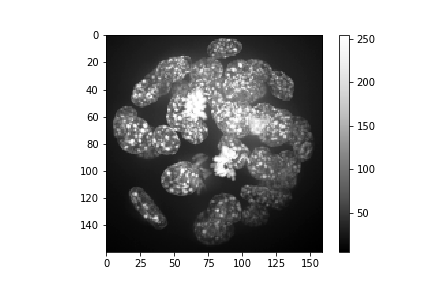
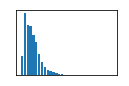

In [10]:
resampled_zoomed

## 练习 
增加缩放因子并重新运行上面的代码。在哪个缩放因子下程序会崩溃？如果不崩溃，生成的图像会有多大？你的显卡有多少内存？